In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
import time
import random
import itertools
# import threading
# from collections import defaultdict
from datetime import datetime
from decimal import Decimal

from tensorflow.compat.v1 import keras
from tensorflow.compat.v1.keras import backend as K
import tensorflow.compat.v1 as tf
import mdn

# import tensorflow as tf
# from tensorflow import keras

In [2]:
!pwd

/uio/kant/ifi-ansatt-u07/cagrie/privat/coadaptation


### GPU

In [3]:
print(tf.__version__)

2.4.1


In [4]:
# physical_devices = tf.config.list_physical_devices('GPU')
# print("Num GPUs:", len(physical_devices))

In [5]:
# from tensorflow.core.protobuf import rewriter_config_pb2
# #tf.disable_eager_execution()

# # set GPU config
# # CUDA_VISIBLE_DEVICES = "" will force GPU use
# #os.environ["CUDA_VISIBLE_DEVICES"] = ""
# config = tf.ConfigProto()
# config.gpu_options.allow_growth = True
# config.log_device_placement=True
# config.allow_soft_placement=True
# #config.gpu_options.per_process_gpu_memory_fraction=0.8

In [6]:
# os.environ["CUDA_VISIBLE_DEVICES"] = ""
# os.environ["CUDA_VISIBLE_DEVICES"]= "0" # first gpu
# os.environ["CUDA_VISIBLE_DEVICES"]= "1" # second gpu
# os.environ["CUDA_VISIBLE_DEVICES"]= "2" # third gpu

# os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

config = tf.ConfigProto()
G = len(tf.config.experimental.list_physical_devices('GPU'))
print("Num GPUs Available: ", G)
print("tf version ", tf.__version__)
print("keras version ", tf.keras.__version__)

Num GPUs Available:  3
tf version  2.4.1
keras version  2.4.0


### Import data

In [7]:
npydir = "./datasets/npy_proc_ds_f_L/"

with open(os.path.join(npydir,'dataset_info.txt')) as text:
    dataset_info = [line.rstrip('\n') for line in text]

In [8]:
dataset_info

['1-p01-bending_soft_70 ',
 '2-p01-bending_strong_70 ',
 '3-p01-on-off_soft_70 ',
 '4-p01-on-off_strong_70 ',
 '5-p01-sustained_soft_70 ',
 '6-p01-sustained_strong_70 ',
 '7-p01-iterative_soft_70 ',
 '8-p01-iterative_strong_70 ',
 '9-p01-free_encore_100 ',
 '10-p01-free_70 ',
 '11-p02-bending_soft_70 ',
 '12-p02-bending_strong_70 ',
 '13-p02-on-off_soft_70 ',
 '14-p02-on-off_strong_70 ',
 '15-p02-sustained_soft_70 ',
 '16-p02-sustained_strong_70 ',
 '17-p02-iterative_soft_70 ',
 '18-p02-iterative_strong_70 ',
 '19-p02-free_encore_100 ',
 '20-p03-bending_soft_70 ',
 '21-p03-bending_strong_70 ',
 '22-p03-on-off_soft_70 ',
 '23-p03-on-off_strong_70 ',
 '24-p03-sustained_soft_70 ',
 '25-p03-sustained_strong_70 ',
 '26-p03-iterative_soft_70 ',
 '27-p03-iterative_strong_70 ',
 '28-p03-free_encore_100 ',
 '29-p03-free_70 ',
 '30-p04-bending_soft_70 ',
 '31-p04-bending_strong_70 ',
 '32-p04-on-off_soft_70 ',
 '33-p04-on-off_strong_70 ',
 '34-p04-sustained_soft_70 ',
 '35-p04-sustained_strong_7

In [9]:
participants = [p.split('-')[1] for p in dataset_info]
participants = list(dict.fromkeys(participants))

impros=[]
for idx, s in enumerate(dataset_info):
    if s.count('free'):
        impros.append(idx)

print(f"{len(impros)} improvisations & {len(participants)*8} tasks ({len(dataset_info)} recordings).")

72 improvisations & 256 tasks (328 recordings).


In [10]:
test_input_data = np.load(os.path.join(npydir, 'sample_76.npy'))
test_time = np.linspace(0, len(test_input_data)/50, len(test_input_data))
test_input_data.shape

(1310, 7)

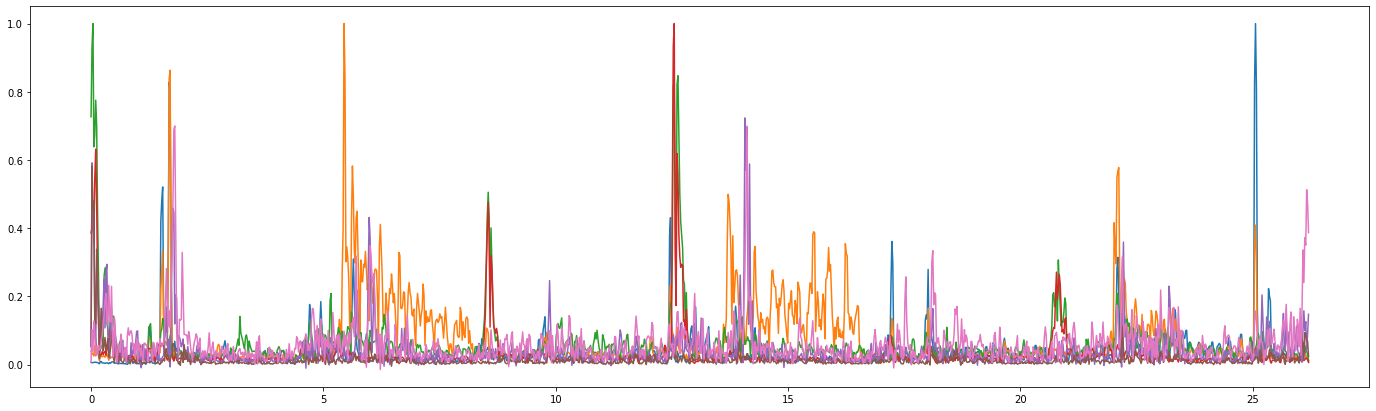

In [11]:
plt.figure(figsize=(24,7))
plt.plot(test_time, test_input_data[:,:]) #while playing an 'impulsive' task
plt.show();

## Load data

In [12]:
def make_windows(arr, win_size, step_size, distance):
    '''
    Sliding-window segmentation of inputs and targets.
    Step size: non-overlapped area, 
    distance: the sample-based distance between input and target start pts. 
    '''
    x_list, y_list = [],[]
    x_len = arr.shape[0]
    remainder = (x_len - win_size) % step_size 
    num_windows = 1 + int((x_len - distance - win_size - remainder) / step_size)
    
#     print('Num windows:', num_windows)
    if distance >= x_len:
        raise ValueError(f"Distance cannot be greater than the array length ({arr.shape})")
        
    for k in range(num_windows):
        x_list.append(arr[k*step_size : win_size-1+ k*step_size +1])
        y_list.append(arr[(k*step_size) + distance : win_size-1+ k*step_size + 1 + distance])

    return np.array(x_list), np.array(y_list)

In [13]:
def generate_indexes(path, n_data, val_split=0.2, dat_info=dataset_info, only_impros=False):

    #calculate the lengths of train and test sets
    if n_data >= 2 and n_data < len(dataset_info):
        splitted = int(np.floor(n_data * val_split))
        n_val = 1 if splitted == 0 else splitted
        n_train = n_data - n_val
    elif n_data > len(dataset_info):
        raise ValueError(f'n_data cannot be greater than {len(dataset_info)}')
    else:
        raise ValueError("n_data has to be greater than or equal to 2")
    
    #divide impros and tasks
    dataset = [dat for dat in range(len(dat_info))] 
    tasks=[]
    for el in dataset:
        if el not in impros:
            tasks.append(el)
            
    if only_impros:
        if n_data <= len(impros):
            train_list = impros
        else:
            raise ValueError(f'n_data cannot be greater than {len(impros)} if only_impros=True')
    else:
        train_list = [x for x in itertools.chain.from_iterable(itertools.zip_longest(impros,tasks)) if x]
        
    data_list_dir = [os.path.join(path, 'sample_'+str(s)+'.npy') for s in train_list]  
    train_list_dir = data_list_dir[:n_train]
    val_list_dir = data_list_dir[n_train:n_train+n_val]
    
    t_and_v_dirs = train_list_dir + val_list_dir
    test_list_dir = [r for r in t_and_v_dirs + data_list_dir if r not in t_and_v_dirs or r not in data_list_dir]
    
    if len(test_list_dir) > len(val_list_dir):
        test_list_dir = test_list_dir[:len(val_list_dir)]
    else:
        test_list_dir = test_list_dir
    
    return train_list_dir, val_list_dir, test_list_dir

In [14]:
def steps_per_epoch(train_dirs, val_dirs, test_dirs, batch_size, win_size, step_size, distance):
    '''
    Calculate the total nr of iterations per epoch (separately for train, val and test lists).
    '''
    def steps_of(dirs):
        steps=0
        for s in dirs:
            arrlen = np.load(s).shape[0]
            arr_win_len = 1 + int((arrlen - distance - win_size -\
                                 ((arrlen - win_size) % step_size )) / step_size)  
            steps += int(np.floor(arr_win_len / batch_size))
        return steps-1
    
    return steps_of(train_dirs), steps_of(val_dirs), steps_of(test_dirs)

In [15]:
class DatasetGenerator(tf.data.Dataset):
    
    OUTPUT_TYPES = (tf.float32, tf.float32)
    
    def _generator(data_list_dir, batch_size, steps_per_epoch, win_size, 
                   n_features, step_size, distance, shuffle=False, verbose=False):

        while True:
            
            if shuffle:
                random.shuffle(data_list_dir)

            for e, dat_path in enumerate(data_list_dir):

                example = np.load(dat_path)
                input_windows, target_windows = make_windows(example, 
                                                             win_size=win_size, 
                                                             step_size=step_size, 
                                                             distance=distance)

                step = 0
                drop_last_steps = int(np.floor(input_windows.shape[0]/batch_size)) * batch_size
                
                if verbose:
                    print(f'Example-{e+1} at {dat_path} with shape: {input_windows.shape}')
                    print('Total steps:', drop_last_steps)
                

                source, target = [],[]
                batch_count = 1  
#                 while (step < drop_last_steps) and (step < input_windows.shape[0]): 
                for (x,y) in zip(input_windows, target_windows):

                    x_train, y_train = np.empty((batch_size, win_size, n_features)), _

                    source.append(x)
                    target.append(y)
                    step += 1
                    batch_count += 1

                    if batch_count > batch_size:
                        x_train = np.array(source).astype('float32')
                        y_train = np.array(target).astype('float32')
                        yield x_train, y_train

                        if verbose:
                            print(f'First val of EMG_R ch1: {x_train[0,0,0]}')
                            print(f"Total yielded windows: {step} * ({win_size},{n_features})")

                        source, target = [],[] #reset batch-lists and batch-count
                        batch_count = 1
    
    def __new__(cls, data_list_dir, batch_size, steps_per_epoch, win_size, 
                   n_features, step_size, distance, shuffle=False, verbose=False):
        return tf.data.Dataset.from_generator(
                 cls._generator,
                 output_types=cls.OUTPUT_TYPES,
                 output_shapes=(tf.TensorShape([batch_size, win_size, n_features]), 
                                tf.TensorShape([batch_size, win_size, n_features])),
                 args=(data_list_dir, batch_size, steps_per_epoch, win_size, 
                                   n_features, step_size, distance, shuffle, verbose,)
                )

### Hparams

##### Notes:
20201103: Next time increase the nr of epochs drastically (100+) w patience at 10, and try mixed-precision multi-gpu but don't spend much time on it.

In [18]:
HIDDEN_UNITS1 = 32 # number of hidden units
HIDDEN_UNITS2 = HIDDEN_UNITS1 #* 2
N_MIXES =  5 # number of mixture components 
INPUT_DIMS = 7
OUTPUT_DIMS = 7
BATCH_SIZE = 512
N_TRAIN = 300 #total: 328 (impros+tasks) or 72 (only impros)
SEQ_LEN = 100 #window length 1s
STEP_SIZE = 1 #non-overlapping areas between successive windows
DISTANCE = 1 #distance between the input and output sequences
PATH = npydir

EPOCHS = 200
d = 0.2  #0.5 # Dropout rate
lr = 0.00001 
VAL_SPLIT = 0.15

TRAIN_LIST, VAL_LIST, TEST_LIST = generate_indexes(path=PATH, 
                                                   n_data=N_TRAIN, 
                                                   val_split=VAL_SPLIT, 
                                                   dat_info=dataset_info,
                                                   only_impros=False)

TRAIN_STEPS, VAL_STEPS, TEST_STEPS = steps_per_epoch(train_dirs=TRAIN_LIST, 
                                                     val_dirs=VAL_LIST,
                                                     test_dirs=TEST_LIST,
                                                     batch_size=BATCH_SIZE,
                                                     win_size=SEQ_LEN, 
                                                     step_size=STEP_SIZE,
                                                     distance=DISTANCE)

print(f'{TRAIN_STEPS} training steps per epoch for {len(TRAIN_LIST)} samples')
print(f'{VAL_STEPS} validation steps per epoch for {len(VAL_LIST)} samples')
print(f'{TEST_STEPS} test steps per epoch for {len(TEST_LIST)} samples')
print(f"{int((len(VAL_LIST)+len(TEST_LIST)) / len(dataset_info) * 100)}% of training examples held for validation")

796 training steps per epoch for 255 samples
122 validation steps per epoch for 45 samples
61 test steps per epoch for 27 samples
21% of training examples held for validation


#### Test

In [19]:
# train_generator = DatasetGenerator(data_list_dir=TRAIN_LIST,
#                                  batch_size=BATCH_SIZE, 
#                                  steps_per_epoch=TRAIN_STEPS, 
#                                  win_size=SEQ_LEN, 
#                                  step_size=STEP_SIZE,
#                                  distance=DISTANCE,
#                                  n_features=INPUT_DIMS,
#                                  verbose=True,
#                                   shuffle=True)

In [20]:
# for step, (x_train, y_train) in enumerate(train_generator):
#     print(f"Step: {step}/{TRAIN_STEPS}")
#     if step >= TRAIN_STEPS:
#         break

# answer = input('-continue? \n-')

### Callbacks

In [21]:
# Setup callbacks
model_dir = "./models/"
date_string = datetime.today().strftime('%Y%m%d-%H_%M_%S')
model_name = f"Coadaptive-{date_string}-{HIDDEN_UNITS1}-{HIDDEN_UNITS2}-{N_MIXES}-{INPUT_DIMS}-{N_TRAIN}\
-{SEQ_LEN}-{STEP_SIZE}-{DISTANCE}-{BATCH_SIZE}-{str(d).replace('.','_')}-{str(lr).replace('.','_')}"

filepath = model_dir + model_name + '.h5'
print('To be saved:', filepath)
checkpoint = keras.callbacks.ModelCheckpoint(filepath,
                                             monitor='val_loss',
                                             verbose=1,
                                             save_best_only=True,
                                             mode='min')

terminateOnNaN = keras.callbacks.TerminateOnNaN()
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', 
                                               mode='min', verbose=1, patience=50)
# m = tf.keras.metrics.Accuracy()

tboard = keras.callbacks.TensorBoard(log_dir='./logs/' + model_name,
                                     histogram_freq=2,
                                     write_graph=True, 
                                     update_freq='epoch')

# NOTE tboard and checkpoint (if h5 name unique) fills up memory quick if model is large.
callbacks = [terminateOnNaN, checkpoint, early_stopping, tboard]

To be saved: ./models/Coadaptive-20210312-11_06_25-32-32-5-7-300-100-1-1-512-0_2-1e-05.h5


## Model

### Time-distributed single-GPU training

In [22]:
inputs = keras.layers.Input(batch_input_shape=(None,SEQ_LEN,INPUT_DIMS), name='inputs')
lstm1 = keras.layers.LSTM(HIDDEN_UNITS1, name='lstm1', return_sequences=True,dropout=d)(inputs)
lstm2 = keras.layers.LSTM(HIDDEN_UNITS2, name='lstm2', return_sequences=True,dropout=d)(lstm1)
mdn_out = keras.layers.TimeDistributed(mdn.MDN(OUTPUT_DIMS, N_MIXES, name='mdn_outputs'), name='td_mdn')(lstm2)    
outputs = keras.layers.Activation('linear', dtype='float32')(mdn_out)

model = keras.models.Model(inputs=inputs, outputs=outputs)

opt = keras.optimizers.Adam(learning_rate=lr)

model.compile(loss=mdn.get_mixture_loss_func(OUTPUT_DIMS,N_MIXES), optimizer=opt)
#, metrics=[mdn.get_mixture_mse_accuracy(1,N_MIXES)]) 
    
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          [(None, 100, 7)]          0         
_________________________________________________________________
lstm1 (LSTM)                 (None, 100, 32)           5120      
_________________________________________________________________
lstm2 (LSTM)                 (None, 100, 32)           8320      
_________________________________________________________________
td_mdn (TimeDistributed)     (None, 100, 75)           2475      
_________________________________________________________________
activation (Activation)      (None, 100, 75)           0         
Total params: 15,915
Trainable params: 15,915
Non-trainable params: 0
_________________________________________________________________


## Training

In [23]:
train_data = DatasetGenerator(data_list_dir=TRAIN_LIST,
                             batch_size=BATCH_SIZE, 
                             steps_per_epoch=TRAIN_STEPS, 
                             win_size=SEQ_LEN, 
                             step_size=STEP_SIZE,
                             distance=DISTANCE,
                             n_features=INPUT_DIMS,
                             shuffle=True,
                             verbose=False).prefetch(tf.data.experimental.AUTOTUNE)

val_data = DatasetGenerator(data_list_dir=VAL_LIST,
                             batch_size=BATCH_SIZE, 
                             steps_per_epoch=VAL_STEPS, 
                             win_size=SEQ_LEN, 
                             step_size=STEP_SIZE,
                             distance=DISTANCE,
                             n_features=INPUT_DIMS,
                             shuffle=True,
                             verbose=False).prefetch(tf.data.experimental.AUTOTUNE)

test_data = DatasetGenerator(data_list_dir=TEST_LIST,
                             batch_size=BATCH_SIZE, 
                             steps_per_epoch=TEST_STEPS, 
                             win_size=SEQ_LEN, 
                             step_size=STEP_SIZE,
                             distance=DISTANCE,
                             n_features=INPUT_DIMS,
                             shuffle=True,
                             verbose=False).prefetch(tf.data.experimental.AUTOTUNE)

Epoch 1/200
Instructions for updating:
Do not pass `graph_parents`.  They will  no longer be used.
796/796 [==============================] - 344s 420ms/step - loss: 6.4848 - val_loss: 6.2875

Epoch 00001: val_loss improved from inf to 6.28747, saving model to ./models/Coadaptive-20210312-11_06_25-32-32-5-7-300-100-1-1-512-0_2-1e-05.h5
Epoch 2/200
796/796 [==============================] - 332s 416ms/step - loss: 5.7755 - val_loss: 1.1420

Epoch 00002: val_loss improved from 6.28747 to 1.14203, saving model to ./models/Coadaptive-20210312-11_06_25-32-32-5-7-300-100-1-1-512-0_2-1e-05.h5
Epoch 3/200
796/796 [==============================] - 325s 409ms/step - loss: -0.0462 - val_loss: -2.2545

Epoch 00003: val_loss improved from 1.14203 to -2.25455, saving model to ./models/Coadaptive-20210312-11_06_25-32-32-5-7-300-100-1-1-512-0_2-1e-05.h5
Epoch 4/200
796/796 [==============================] - 327s 412ms/step - loss: -2.5944 - val_loss: -3.7517

Epoch 00004: val_loss improved from -2.25

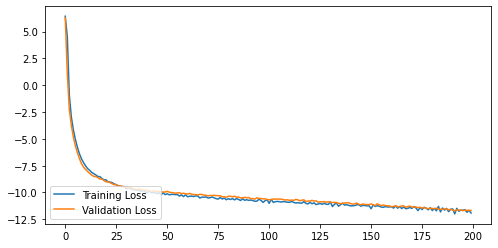

In [24]:
# Fit the model
history = model.fit(train_data, 
                    batch_size=None, 
                    epochs=EPOCHS,
                    steps_per_epoch=TRAIN_STEPS,
                    callbacks=callbacks,
                    validation_data=val_data,
                    validation_steps=VAL_STEPS,
                    shuffle=True,
                    use_multiprocessing=True,
                    workers=1)    

loss_and_metrics = model.evaluate(test_data, 
                   batch_size=None, 
                   verbose=1, 
                   steps=TEST_STEPS, 
                   callbacks=callbacks,
                   use_multiprocessing=True,
                   workers=1)

#save losses as npy files
np.save(os.path.join(model_dir, model_name + '_train_loss'), 
        np.array(history.history['loss']))  
np.save(os.path.join(model_dir, model_name + '_val_loss'), 
        np.array(history.history['val_loss'])) 

# save a txt file with the remaining data dirs for test
with open(os.path.join(model_dir, model_name + '_test_list.txt'), "w") as text_file:
    print(' \n'.join([str(path) for path in TEST_LIST]) , file=text_file)
    
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='lower left')
plt.savefig(os.path.join(model_dir, model_name + '_losses.png'), bbox_inches='tight')
plt.show()